In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

## Data Preprocessing

In [2]:
# set GPU device
gpu = torch.device("mps")

In [3]:
# define initial data transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch size
BATCH_SIZE = 4

# load training images
train_data = torchvision.datasets.CIFAR10(root = '.', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

# load test images
test_data = torchvision.datasets.CIFAR10(root = '.', train = False, download = True, transform = transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

# class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


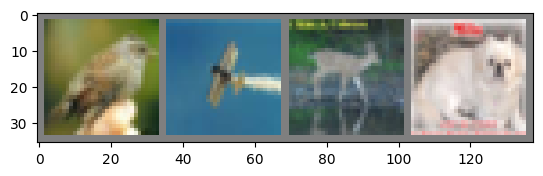

bird  plane deer  dog  


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

## Define Model

In [5]:
# define model architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # model layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, padding = 'same')
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, padding = 'same')
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.lin1 = nn.Linear(in_features = 32 * 8 * 8, out_features = 64)
        self.lin2 = nn.Linear(in_features = 64, out_features = 10)

        # activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 0)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.lin1(x))
        x = self.softmax(self.lin2(x))

        return x

## Train Model

In [6]:
# number of epochs
EPOCHS = 10

# initialize the model
model = Net()

# utilize gpu
model.to(gpu)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

In [7]:
# set random seed
torch.manual_seed(7212023)

# metric tracking lists
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

# train the model
print('Training CNN Model...')

for epoch in range(0, EPOCHS):
    # load model state
    if epoch != 0:
        model.load_state_dict(torch.load(f'./ModelStates/income_mlp_{epoch - 1}.pkl')['model_state_dict'])
    
    # initialize variables to track running metrics
    training_loss = 0.0
    training_acc = 0.0
    num_batches = 0

    # perform training step
    for i, data in enumerate(train_loader, 0):
        # update number of batches
        num_batches += 1

        # get inputs and labels
        inputs, labels = data[0].to(gpu), data[1].to(gpu)

        # forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # TODO: save training accuracy
        
        # backward pass
        loss.backward()
        optimizer.step()

        # save training loss
        training_loss += loss.item()

        # clear gradients
        optimizer.zero_grad()
    
    train_loss.append(training_loss / num_batches)
    # TODO: save training accuracy

    # initialize variables to track running metrics
    validation_loss = 0.0
    validation_acc = 0.0
    num_batches = 0

    # perform validation step
    for i, data in enumerate(test_loader, 0):
        # update number of batches
        num_batches += 1

        # get inputs and labels
        inputs, labels = data[0].to(gpu), data[1].to(gpu)

        # forward pass
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()

            # TODO: save validation accuracy
        
    valid_loss.append(validation_loss / num_batches)
    # TODO: save validation accuracy

    # print the average loss for the epoch
    print(f"Epoch {epoch + 1} - Validation Loss: {np.round(validation_loss / num_batches, 7)}")
    # print(f"Epoch {epoch + 1} - Validation Loss: {np.round(validation_loss / num_batches, 7)} | Validation Accuracy: {np.round(validation_acc / num_batches * 100, 2)}%")

    # save model state
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                './ModelStates/income_mlp_' + str(epoch) + '.pkl')

# calculate training time
end_time = time.time()
print(f'Model Trained In {np.round(end_time - start_time, 2)} Seconds')

Training CNN Model...


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## Model Evaluation